# Sheet 7

In [2]:
# Import packages
import pandas as pd
#from numpy.linalg import inv
##from scipy.optimize import root_scalar
from scipy.optimize import fsolve
import torch as tc
import torch.nn as nn
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt

## Backpropagation Through Time
**Analytically find formulas for the gradients:**

$$\frac{\partial L}{\partial w} = \sum_{t=1}^T \frac{\partial}{\partial w} (x_t - w z_t)^2 = \sum_{t=1}^T 2(x_t - w z_t)(-z_t)= -2 \sum_{t=1}^T (x_t - w z_t) z_t$$

$$\nabla_w L = -2 \sum_{t=1}^T (x_t - w z_t) z_t$$

Let $a_t = u z_{t-1} + v x_{t-1}$ so that $z_t = \varphi(a_t)$. Define:
$$\delta_t := \frac{\partial z_t}{\partial u}$$
We apply the chain rule:
$$\delta_t = \varphi'(a_t) \left(z_{t-1} + u \delta_{t-1} \right), \quad \delta_0 = 0$$
Then:
$$\nabla_u L = \sum_{t=1}^T \frac{\partial L}{\partial z_t} \cdot \delta_t = -2 \sum_{t=1}^T (x_t - w z_t) w \delta_t$$

Similarly, define:
$$\eta_t := \frac{\partial z_t}{\partial v}$$
$$\eta_t = \varphi'(a_t) \left(x_{t-1} + u \eta_{t-1} \right), \quad \eta_0 = 0$$
Then:
$$\nabla_v L = -2 \sum_{t=1}^T (x_t - w z_t) w \eta_t$$

**Find conditions for the gradients such that they neither vanish nor explode**

Consider first
$$\nabla_u L = -2 \sum_{t=1}^T (x_t - w z_t) w \delta_t$$

We assume that $x_t$, and $z_t$ are bounded. The behaviour of the sum is then dermined by the behaviour of $\delta_t$. $\delta_t$ is defined recursively by
$$\delta_t = \gamma_t (z_{t-1} + u \delta_{t-1}) = \ldots = \sum_{k=1}^t u^{k-1} \prod_{j=0}^{k-1} \gamma_{t-j} z_{t-k}$$
Where $\gamma_t = \phi'(a_t)$. Assuming $\gamma_t \approx \gamma$ we get
$$\delta_t = \sum_{k=1}^t u^{k-1} \gamma^{k} z_{t-k} = \sum_{k=1}^t (u\gamma)^{k} \frac{z_{t-k}}{u}$$
We recognize the sum as a geometric series, which is known to diverge if $|u\gamma|>1$ and converge to $0$ if $|u\gamma|<1$. For $|u\gamma| \approx 1$ $\delta_t$ will remain informative. Therefore to prevent an exploding and vanishing gradient we need
$$|\phi'(a_t) u| \approx 1 \quad , \quad \forall t$$
The same condition arises when considering $\nabla_v L$, and regarding $\nabla_v L$, we are never in danger of a vanishing or exploding gradiant. 

## The Influence of Noise on the Data

**Using your RNN from last week on the noisy data, find a number of hidden units where the RNN clearly overfits the data**

We start as last time by plotting the data, and defining the model. 

In [3]:
hidden_size = 32  

# Training parameters
epochs = 1500
learning_rate = 0.01 

Data shape: torch.Size([41, 2])
Observation size: 2
Time steps: 41


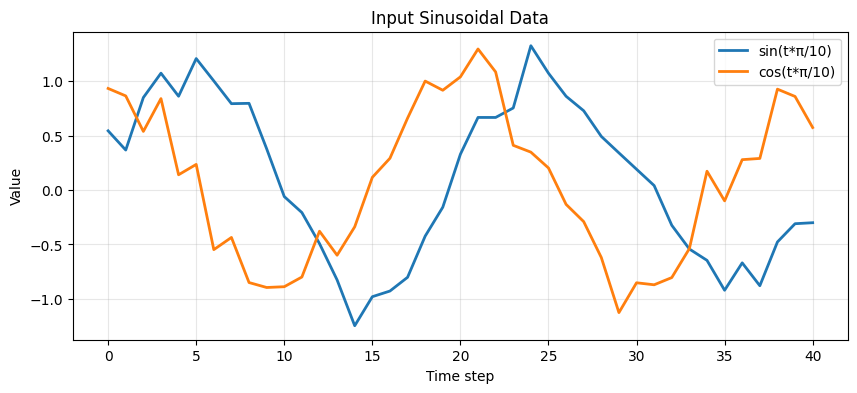

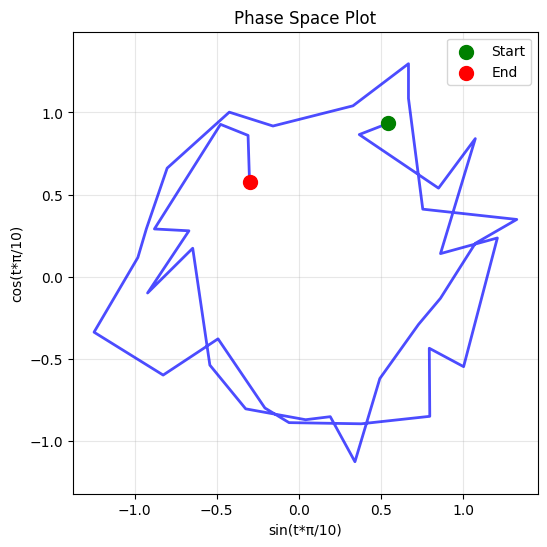

In [4]:
data = tc.load('noisy_sinus.pt')
observation_size = data.shape[1]  # Should be 2 (sin and cos components)

print(f"Data shape: {data.shape}")
print(f"Observation size: {observation_size}")
print(f"Time steps: {data.shape[0]}")

# Plot the input data
plt.figure(figsize=(10, 4))
plt.plot(data[:, 0], label='sin(t*π/10)', linewidth=2)
plt.plot(data[:, 1], label='cos(t*π/10)', linewidth=2)
plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('Input Sinusoidal Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot phase space (sin vs cos)
plt.figure(figsize=(6, 6))
plt.plot(data[:, 0], data[:, 1], 'b-', linewidth=2, alpha=0.7)
plt.scatter(data[0, 0], data[0, 1], c='green', s=100, label='Start', zorder=5)
plt.scatter(data[-1, 0], data[-1, 1], c='red', s=100, label='End', zorder=5)
plt.xlabel('sin(t*π/10)')
plt.ylabel('cos(t*π/10)')
plt.title('Phase Space Plot')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

In [5]:
#%% MODEL DEFINITION
class LatentRNN(nn.Module):
    """
    Recurrent Neural Network for learning dynamical systems
    
    Architecture:
    z_t = tanh(C * x_{t-1} + W * z_{t-1} + h)  # Hidden state update
    \hat{x}_t = B * z_t + c                    # Output generation
    """
    
    def __init__(self, obs_dim, latent_dim, dropout=0.0):
        super(LatentRNN, self).__init__()

        self.obs_dim = obs_dim        # Dimension of observations (2 for sin/cos)
        self.latent_dim = latent_dim  # Dimension of hidden state z_t
   
        # 1. Input-to-hidden transformation: U matrix and bias b # Input-to-hidden (C * x_{t-1} + h)
        self.input_to_hidden = nn.Linear(obs_dim, latent_dim)
        # 2. Hidden-to-hidden transformation: V matrix  # Hidden-to-hidden (W * z_{t-1})
        self.hidden_to_hidden = nn.Linear(latent_dim, latent_dim, bias=False)
        # 3. Hidden-to-output transformation: W matrix and bias c # Hidden-to-output (B * z_t + c)
        self.hidden_to_output = nn.Linear(latent_dim, obs_dim)

        # Dropout 
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, time_series, h0):
        """
        Forward pass through the RNN
        
        Args:
            time_series: Input sequence of shape (seq_len, batch_size, obs_dim)
            h0: Initial hidden state of shape (1, batch_size, latent_dim)
            
        Returns:
            obs_output: Predicted observations of shape (seq_len, batch_size, obs_dim)
            h: Final hidden state of shape (1, batch_size, latent_dim)
        """

        seq_len, batch_size, obs_dim = time_series.size()
        h = h0.squeeze(0)
        
        outputs = []
        for t in range(seq_len):
            x_t = time_series[t]
            h = tc.tanh(self.input_to_hidden(x_t) + self.hidden_to_hidden(h))
            h = self.dropout(h)
            x_hat = self.hidden_to_output(h)
            outputs.append(x_hat)

        obs_output = tc.stack(outputs, dim=0)
        return obs_output, h.unsqueeze(0)
    

# Initialize the model

model = LatentRNN(observation_size, hidden_size)
# Print model information
print(f"\nModel Architecture:")
print(f"- Observation dimension: {observation_size}")
print(f"- Hidden dimension: {hidden_size}")
print(f"- Total parameters: {sum(p.numel() for p in model.parameters())}")


Model Architecture:
- Observation dimension: 2
- Hidden dimension: 32
- Total parameters: 1186


In [6]:
def train(model, learning_rate, moment=0, optimizer_function='SGD', print_loss=True, batch_size=1, batch_sequence_length=1, regul = None):
    """
    Training function with configurable optimizers and mini-batching
    """
    
    if optimizer_function == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=moment)
    elif optimizer_function == 'ADAM':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_function}")
    
    # Use Mean Squared Error (MSE) loss for this regression task
    loss_function = nn.MSELoss()
    
    losses = []
    
    print(f"\nStarting training for {epochs} epochs...")
    print(f"Optimizer: {optimizer_function}, LR: {learning_rate}, Batch size: {batch_size}, Sequence length: {batch_sequence_length}")
    
    for epoch in range(epochs):
        # Create a tensor of shape (1, batch_size, hidden_size) with random values (the hidden states)
        h0 = tc.zeros((1, batch_size, model.latent_dim))
        
        # Prepare full sequences (input and target)
        x = data[:-1]  # Input: all timesteps except the last
        y = data[1:]   # Target: all timesteps except the first
        
        # Initialize tensors to hold batch data of shape (batch_sequence_length, batch_size, observation_dim):
        X = tc.empty((batch_sequence_length, batch_size, model.obs_dim))
        Y = tc.empty((batch_sequence_length, batch_size, model.obs_dim))
        
        for j in range(batch_size):
            # Sample a random starting index for the subsequence
            # Ensure: 0 <= ind <= len(x) - batch_sequence_length
            ind = tc.randint(0, len(x) - batch_sequence_length + 1, (1,)).item()
            
            # Extract subsequence and assign to batch tensors
            X[:, j, :] = x[ind: ind + batch_sequence_length]
            Y[:, j, :] = y[ind : ind + batch_sequence_length]
        
        # Forward pass
        # 1. Zero the gradients from previous iteration
        optimizer.zero_grad()
        # 2. Run the model forward pass with input X and initial hidden state h0
        output, _ = model.forward(X, h0)
        # 3. Calculate the loss between model output and target Y
        epoch_loss = loss_function(output, Y)
        if (regul != None): penalty = regul(model.parameters())
        else: penalty = 0
        epoch_loss = loss_function(output, Y) + penalty

        
        # Backward pass and optimization step
        # 1. Compute gradients via backpropagation
        epoch_loss.backward()
        # 2. Update model parameters
        optimizer.step()
        
        # Store loss for plotting
        losses.append(epoch_loss.item())
        
        # Print progress
        if epoch % 10 == 0 and print_loss:
            print(f"Epoch: {epoch} loss {epoch_loss.item():.6f}")
    
    return losses

In [7]:
# Train the model
losses = train(model, learning_rate = learning_rate, moment=0, optimizer_function='ADAM', print_loss=False, batch_size=16, batch_sequence_length=40) 


Starting training for 1500 epochs...
Optimizer: ADAM, LR: 0.01, Batch size: 16, Sequence length: 40


In [8]:
# Generate predictions for 5 times the original sequence length
prediction_length = 5 * data.shape[0]

with tc.no_grad():
    h = tc.zeros(1, 1, model.latent_dim)
    predictions = tc.empty((prediction_length, 2))
    
    # Start with first data point
    input_ = data[0:1].unsqueeze(1)  # Shape: (1, 1, obs_dim)

    for i in range(prediction_length):
        output, h = model(input_, h)  
        predictions[i] =  output
        input_ = output

In [9]:
true_vals = [[np.sin(x * np.pi/ (10)) for x in range(1,5 * data.shape[0] +1)], 
             [np.cos(x * np.pi/ (10)) for x in range(1,5 * data.shape[0] +1)]]

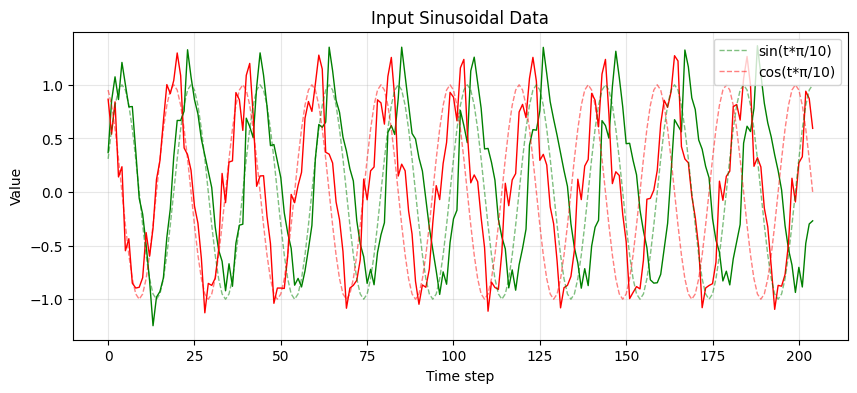

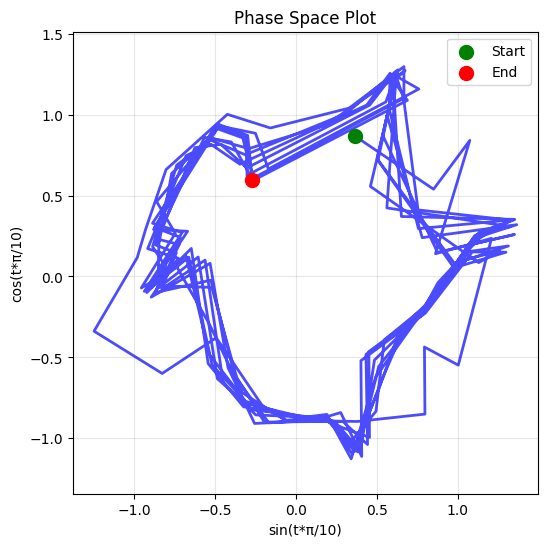

In [10]:
# Plot the predictions
plt.figure(figsize=(10, 4))
plt.plot(predictions[:, 0], linewidth=1, c='green')
plt.plot(predictions[:, 1], linewidth=1, c='red')
plt.plot(true_vals[0], label='sin(t*π/10)', linewidth=1, alpha = 0.5, c='green',  linestyle='dashed')
plt.plot(true_vals[1], label='cos(t*π/10)', linewidth=1, alpha = 0.5, c='red',  linestyle='dashed')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('Input Sinusoidal Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot phase space (sin vs cos)
plt.figure(figsize=(6, 6))
plt.plot(predictions[:, 0], predictions[:, 1], 'b-', linewidth=2, alpha=0.7)
plt.scatter(predictions[0, 0], predictions[0, 1], c='green', s=100, label='Start', zorder=5)
plt.scatter(predictions[-1, 0], predictions[-1, 1], c='red', s=100, label='End', zorder=5)
plt.xlabel('sin(t*π/10)')
plt.ylabel('cos(t*π/10)')
plt.title('Phase Space Plot')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

To choose the hidden parameter size we calculate the MSE of the prediction error for different hidden dimensions: 

In [11]:
def mse_of_hid_par(num, regul = None):
    model_mse = LatentRNN(observation_size, num)
    losses = train(model_mse, learning_rate = learning_rate, moment=0, optimizer_function='ADAM', print_loss=False, batch_size=16, 
                   batch_sequence_length=40, regul = regul)
    prediction_length = 5 * data.shape[0]

    # Train
    with tc.no_grad():
        h = tc.zeros(1, 1, model_mse.latent_dim)
        predictions = tc.empty((prediction_length, 2))
        input_ = data[0:1].unsqueeze(1) 
        for i in range(prediction_length):
            output, h = model_mse(input_, h)  
            predictions[i] =  output
            input_ = output
    
    mse = np.mean((true_vals[0] - np.array(predictions)[:, 0]) ** 2) + np.mean(((true_vals[1]) - np.array(predictions[:, 1])) ** 2)
    return(mse)

In [ ]:
print(mse_of_hid_par(8))
print(mse_of_hid_par(16))
print(mse_of_hid_par(32))
print(mse_of_hid_par(64))
print(mse_of_hid_par(128))


Starting training for 1500 epochs...
Optimizer: ADAM, LR: 0.01, Batch size: 16, Sequence length: 40
1.3302968247495093

Starting training for 1500 epochs...
Optimizer: ADAM, LR: 0.01, Batch size: 16, Sequence length: 40


From the MSE's it looks like the model begins overfitting sometime after a hidden parameter dimension of $16$. In order to clearly achieve overfitting we let the hidden dimensions be equal to 32. 

**Compare the performance of the following strategies to mitigate overfitting: L1-Regularization, L2-Regularization and Dropout**

We define the alternative loss functions. 

In [ ]:
alpha = 0.1
def regul_l1(par):
    # something looks weird, maybe this can fix it
    # tc.stack([p.abs().sum() for p in par if p.requires_grad]).sum()
    return(alpha * sum(p.abs().sum() for p in par))

def regul_l2(par):
   return(alpha * sum((p ** 2).sum() for p in par))

*L1 and L2 Regularization* 

These methods counteract overfitting as they penalizes parameter size. There is a tradeoff in loss between likelihood increase and parameter size. We find the MSE of predictions for different alpha values and hidden dimension size of 32 in the following: 

In [ ]:
alpha = 0.1
print(f"L1 and L2 for alpha = {alpha}")
print(mse_of_hid_par(32, regul = regul_l1))
print(mse_of_hid_par(32, regul = regul_l2))
alpha = 0.4
print(f"L1 and L2 for alpha = {alpha}")
print(mse_of_hid_par(32, regul = regul_l1))
print(mse_of_hid_par(32, regul = regul_l2))
alpha = 0.6
print(f"L1 and L2 for alpha = {alpha}")
print(mse_of_hid_par(32, regul = regul_l1))
print(mse_of_hid_par(32, regul = regul_l2))

L1 and L2 for alpha = 0.1

Starting training for 1500 epochs...
Optimizer: ADAM, LR: 0.01, Batch size: 16, Sequence length: 40
0.9932726175252096

Starting training for 1500 epochs...
Optimizer: ADAM, LR: 0.01, Batch size: 16, Sequence length: 40
0.8791826358256526
L1 and L2 for alpha = 0.4

Starting training for 1500 epochs...
Optimizer: ADAM, LR: 0.01, Batch size: 16, Sequence length: 40
0.9999945483987449

Starting training for 1500 epochs...
Optimizer: ADAM, LR: 0.01, Batch size: 16, Sequence length: 40
1.0007998169796057
L1 and L2 for alpha = 0.6

Starting training for 1500 epochs...
Optimizer: ADAM, LR: 0.01, Batch size: 16, Sequence length: 40
1.000056740945384

Starting training for 1500 epochs...
Optimizer: ADAM, LR: 0.01, Batch size: 16, Sequence length: 40
1.0001596678959819


The lowest MSE is achieved for alpha = 0.1 and l2 regularization. For higher alpha's the MSE is always around 1 for both methods. Note that without regularization the model with hidden parameter dimension had a MSE of around 1.5 as opposed to 0.92. 

We plot the predictions from a model with alpha = 0.05 and L2 regularization:


Starting training for 1500 epochs...
Optimizer: ADAM, LR: 0.01, Batch size: 16, Sequence length: 40


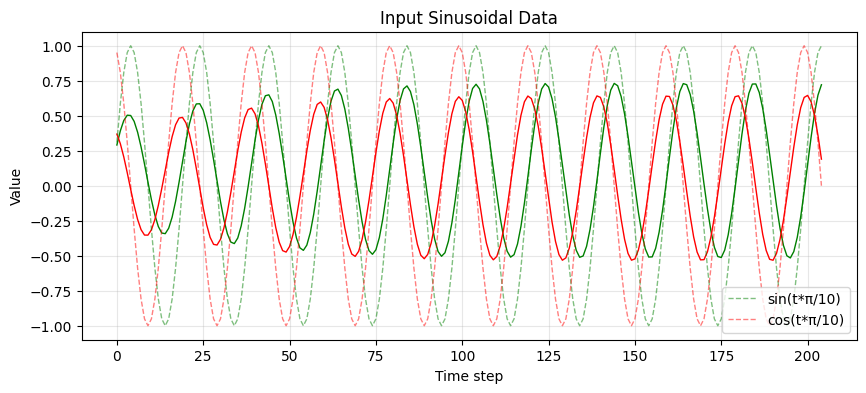

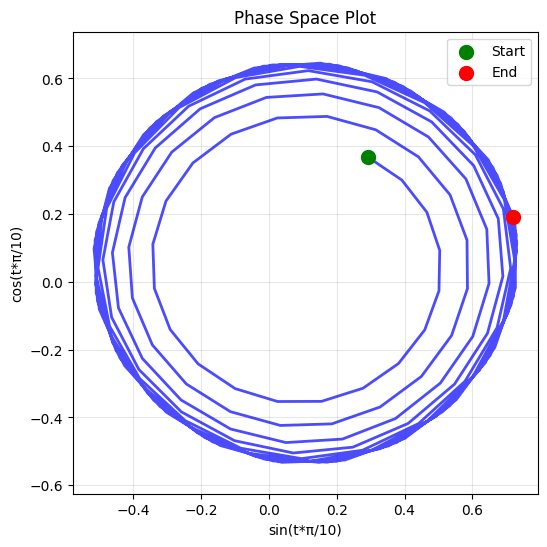

In [ ]:
alpha = 0.05
model_l2 = LatentRNN(observation_size, 32)
losses = train(model_l2, learning_rate = learning_rate, moment=0, optimizer_function='ADAM', print_loss=False, batch_size=16, 
                batch_sequence_length=40, regul = regul_l2)
prediction_length = 5 * data.shape[0]

with tc.no_grad():
    h = tc.zeros(1, 1, model_l2.latent_dim)
    predictions = tc.empty((prediction_length, 2))
    
    # Start with first data point
    input_ = data[0:1].unsqueeze(1)  # Shape: (1, 1, obs_dim)

    for i in range(prediction_length):
        output, h = model_l2(input_, h)  
        predictions[i] =  output
        input_ = output
        
# Plot the predictions
plt.figure(figsize=(10, 4))
plt.plot(predictions[:, 0], linewidth=1, c='green')
plt.plot(predictions[:, 1], linewidth=1, c='red')
plt.plot(true_vals[0], label='sin(t*π/10)', linewidth=1, alpha = 0.5, c='green',  linestyle='dashed')
plt.plot(true_vals[1], label='cos(t*π/10)', linewidth=1, alpha = 0.5, c='red',  linestyle='dashed')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('Input Sinusoidal Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot phase space (sin vs cos)
plt.figure(figsize=(6, 6))
plt.plot(predictions[:, 0], predictions[:, 1], 'b-', linewidth=2, alpha=0.7)
plt.scatter(predictions[0, 0], predictions[0, 1], c='green', s=100, label='Start', zorder=5)
plt.scatter(predictions[-1, 0], predictions[-1, 1], c='red', s=100, label='End', zorder=5)
plt.xlabel('sin(t*π/10)')
plt.ylabel('cos(t*π/10)')
plt.title('Phase Space Plot')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

*c. Dropout*

It prevents the network from becoming too reliant on any particular neuron, thereby counteracting overfitting. 


Starting training for 1500 epochs...
Optimizer: ADAM, LR: 0.01, Batch size: 16, Sequence length: 40


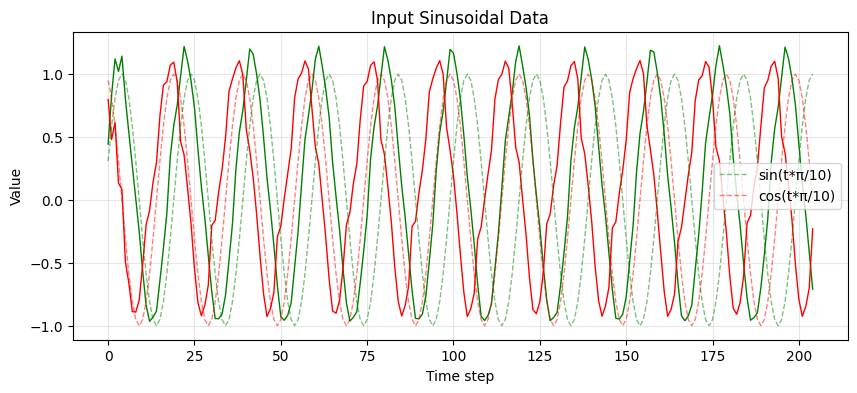

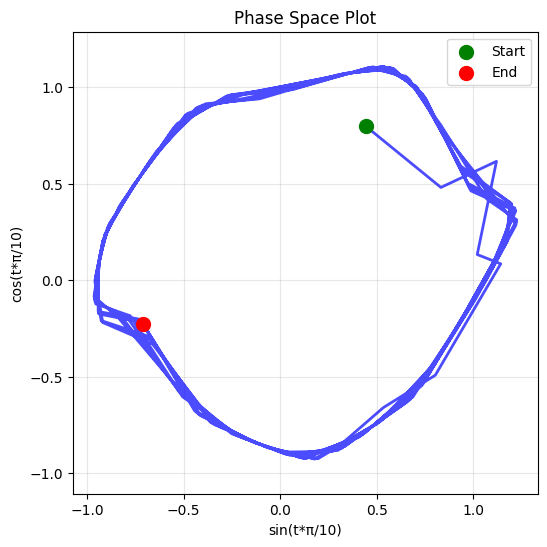

In [15]:
model_dropout = LatentRNN(observation_size, hidden_size, dropout = 0.3)  # Dropout of 30%
model_dropout.train()
losses = train(model_dropout, learning_rate = learning_rate, moment=0, optimizer_function='ADAM', print_loss=False, batch_size=16, 
                batch_sequence_length=40)
model_dropout.eval()

prediction_length = 5 * data.shape[0]

with tc.no_grad():
    h = tc.zeros(1, 1, model_dropout.latent_dim)
    predictions = tc.empty((prediction_length, 2))
    
    # Start with first data point
    input_ = data[0:1].unsqueeze(1)  # Shape: (1, 1, obs_dim)

    for i in range(prediction_length):
        output, h = model_dropout(input_, h)  
        predictions[i] =  output
        input_ = output
        
# Plot the predictions
plt.figure(figsize=(10, 4))
plt.plot(predictions[:, 0], linewidth=1, c='green')
plt.plot(predictions[:, 1], linewidth=1, c='red')
plt.plot(true_vals[0], label='sin(t*π/10)', linewidth=1, alpha = 0.5, c='green',  linestyle='dashed')
plt.plot(true_vals[1], label='cos(t*π/10)', linewidth=1, alpha = 0.5, c='red',  linestyle='dashed')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('Input Sinusoidal Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot phase space (sin vs cos)
plt.figure(figsize=(6, 6))
plt.plot(predictions[:, 0], predictions[:, 1], 'b-', linewidth=2, alpha=0.7)
plt.scatter(predictions[0, 0], predictions[0, 1], c='green', s=100, label='Start', zorder=5)
plt.scatter(predictions[-1, 0], predictions[-1, 1], c='red', s=100, label='End', zorder=5)
plt.xlabel('sin(t*π/10)')
plt.ylabel('cos(t*π/10)')
plt.title('Phase Space Plot')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()